In [12]:
import numpy as np
import random
import cv2
import math
import matplotlib
from matplotlib import pyplot as plt
from PIL import Image
from PIL.ExifTags import TAGS 
%matplotlib inline

个人理解（有错误还望能指出）：  
在数字图像中，dpi的概念实际上并不重要，dpi对于需要打印的图像来说才有实际的含义  
dpi原本的概念为:dots per inch，即每英寸需要打印多少点  
对于大小同样为(100px,100px）的图片，第一幅dpi=10，第二幅dpi=100  
那么，第一幅打印出的大小为100/10=10英寸，第二幅打印出的大小为100/100=1英寸  
甚至电子图片不具备dpi信息都是允许的  

In [23]:
# 例如，直接用api可以改变图像dpi
im1250 = Image.open('images/Fig0220(a)(chronometer 3692x2812  2pt25 inch 1250 dpi).tif')
meta_dict = {TAGS[key] : im1250.tag[key] for key in im1250.tag.keys()}
print('original image dpi',meta_dict['XResolution'][0][0]/meta_dict['XResolution'][0][1]) # 输出：1250

# 更改dpi信息并储存
im1250.save("images/Fig0220(b)(chronometer 3692x2812  72 dpi).tif", dpi=(72,72))
im72 = Image.open('images/Fig0220(b)(chronometer 3692x2812  72 dpi).tif')
meta_dict2 = {TAGS[key] : im72.tag[key] for key in im72.tag.keys()}
print('changed image dpi',meta_dict2['XResolution'][0][0]/meta_dict2['XResolution'][0][1]) # 输出：72

# 两个图片在电子设备中，没有太多差异，只是在打印时，dpi高的那幅图物理尺寸会更小

original image dpi 1250.0
changed image dpi 72.0


In [25]:
img_resize1 = im1250.resize((162,213))
img_resize1.save('images/test.tif')# 直接保存不会有dpi信息（即分辨率信息）,也进一步验证，在数字图像中，dpi对显示并不重要
img_resize1.save('images/Fig0220(c)(chronometer 213x162  72 dpi).tif',dpi=(72,72))

**模拟得到低分辨率dpi图像**

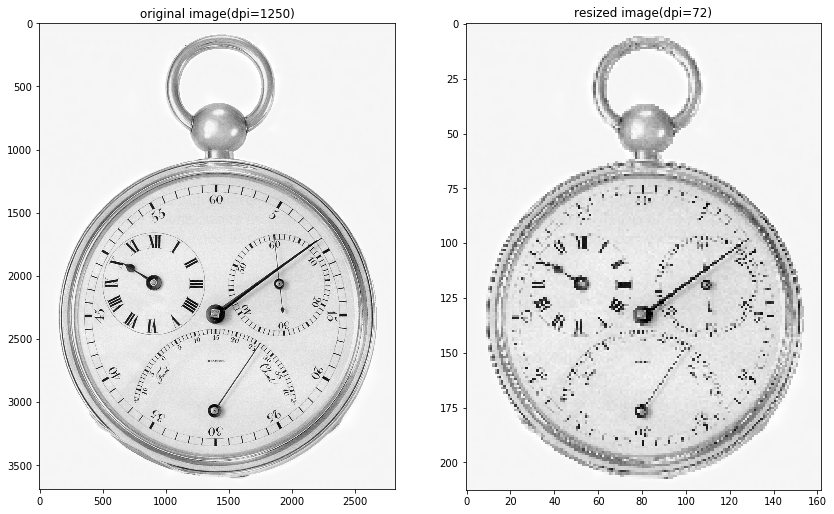

In [26]:
im1 = Image.open('images/Fig0220(a)(chronometer 3692x2812  2pt25 inch 1250 dpi).tif')
im2 = Image.open('images/Fig0220(c)(chronometer 213x162  72 dpi).tif')
ax = []
fig=plt.figure(figsize=(14, 14))
ax.append(fig.add_subplot(1, 2, 1))
ax[-1].set_title("original image(dpi=1250)")
plt.imshow(im1)

ax.append(fig.add_subplot(1, 2, 2))
ax[-1].set_title("resized image(dpi=72)")
plt.imshow(im2)


plt.show()

## 1. Image Interpolation

**用于展示的工具函数**

In [9]:
def result_show_interp(image,output,resized):
    ax = []
    fig=plt.figure(figsize=(14, 14))
    ax.append(fig.add_subplot(1, 3, 1))
    ax[-1].set_title("origin image")
    plt.imshow(image)
    
    ax.append(fig.add_subplot(1, 3, 2))
    ax[-1].set_title("my interp")
    plt.imshow(output)
    
    ax.append(fig.add_subplot(1, 3, 3))
    ax[-1].set_title("opencv interp")
    plt.imshow(resized)
    
    plt.show()

In [2]:
""" 读入图片(灰度图|彩色图)"""
path = 'images/Fig0220(c)(chronometer 213x162  72 dpi).tif'
image = cv2.imread(path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = image.astype(float)/255.
print("原图尺寸", image.shape)
"""创建空目标图像"""
k = 2 # 缩放比例，k=2表示扩大两倍
output_shape = (3692,2812,3)# 这儿虽然是灰度图像，也加上了channel通道，为了演示彩色图像的插值过程
print("输出尺寸", output_shape)

原图尺寸 (213, 162, 3)
输出尺寸 (3692, 2812, 3)


### Nearest Neighbor Interpolation

In [35]:
"""最邻近插值"""
def my_nearest_interp(image, output_shape): 
    output = np.zeros(output_shape, dtype=image.dtype)
    ratio_height = image.shape[0]*1.0/output_shape[0]
    ratio_width = image.shape[1]*1.0/output_shape[1]
    # 遍历目标图片
    for c in range(output.shape[-1]):
        for row in range(output.shape[0]):
            for col in range(output.shape[1]):

                # 获取其在原图像上的坐标位置
                origin_row = row*ratio_height 
                origin_col = col*ratio_width           

                # 获取其最临近的点
                a = min(max(int(round(origin_row)),0),image.shape[0]-1)
                b = min(max(int(round(origin_col)),0),image.shape[1]-1)

                output[row,col,c] = image[a,b,c]
    return output

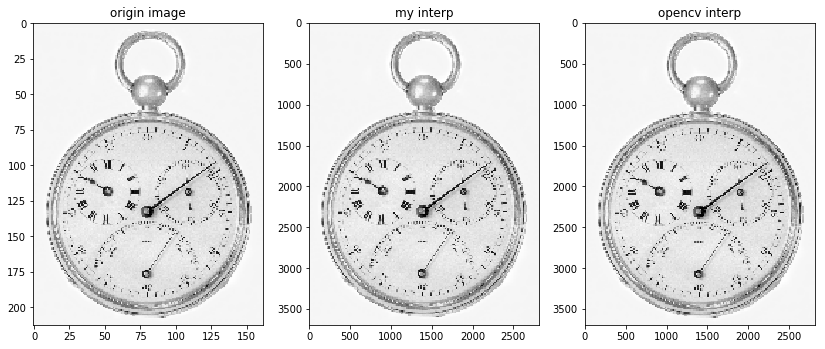

'保存结果为图片'

In [36]:
nearest_opencv = cv2.resize(image, (output_shape[1],output_shape[0]), interpolation=cv2.INTER_NEAREST)
nearest_my = my_nearest_interp(image, output_shape)
"""运行结果展示"""
result_show_interp(image,nearest_my,nearest_opencv)

"""保存结果为图片"""
#matplotlib.image.imsave('images/ch1_my_nearest_interp.png', nearest_my)
#matplotlib.image.imsave('images/ch1_opencv_nearest_interp.png', nearest_opencv)

### Bilinear Interpolation
**利用周围四个点进行插值**

In [37]:
"""双线性插值"""
def my_bilinear_interp(image, output_shape): 
    output = np.zeros(output_shape, dtype=image.dtype)
    ratio_height = image.shape[0]*1.0/output_shape[0]
    ratio_width = image.shape[1]*1.0/output_shape[1]
    # 遍历目标图片
    for ch in range(output.shape[-1]):
        for row in range(output.shape[0]):
            for col in range(output.shape[1]):
                # 获取其在原图像上的坐标位置
                origin_row = (row+0.5)*ratio_height - 0.5 # 需要进行中心对齐
                origin_col = (col+0.5)*ratio_width - 0.5
                # 获取其临近的四个点
                a = int(max(0,math.floor(origin_row)))
                b = int(max(0,math.floor(origin_col)))
                c = int(min(image.shape[0]-1,math.ceil(origin_row)))
                d = int(min(image.shape[1]-1,math.ceil(origin_col)))
                #print(a,b,c,d)
                # 双线性插值函数
                interp_value = image[a,b,ch]*(c-origin_row)*(d-origin_col)+image[a,d,ch]*(c-origin_row)*(origin_col-b)+image[c,b,ch]*(origin_row-a)*(d-origin_col)+image[c,d,ch]*(origin_row-a)*(origin_col-b)
                output[row,col,ch] = interp_value
    return output


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


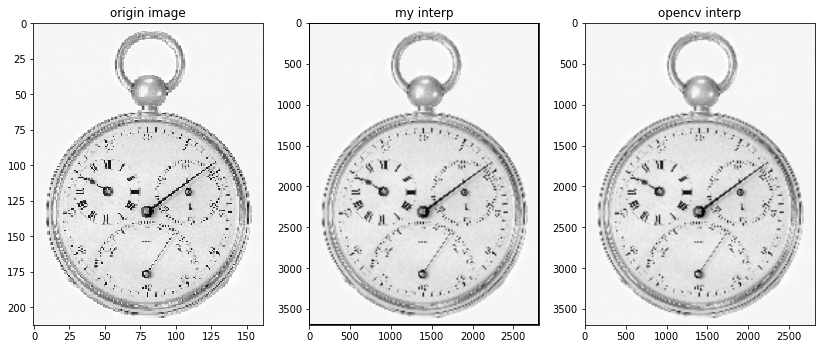

'保存结果为图片'

In [38]:
bilinear_opencv = cv2.resize(image, (output_shape[1],output_shape[0]), interpolation=cv2.INTER_LINEAR)
bilinear_my = my_bilinear_interp(image, output_shape)

"""运行结果展示"""
result_show_interp(image,bilinear_my,bilinear_opencv)

"""保存结果为图片"""
#matplotlib.image.imsave('images/ch1_my_bilinear_interp.png', bilinear_my)
#matplotlib.image.imsave('images/ch1_opencv_bilinear_interp.png', bilinear_opencv)

### Bicubic Interpolation
**利用周围16个点进行插值**

In [5]:
"""双三次插值"""
def u(s,a):
    if (abs(s) >=0) & (abs(s) <=1):
        return (a+2)*(abs(s)**3)-(a+3)*(abs(s)**2)+1
    elif (abs(s) > 1) & (abs(s) <= 2):
        return a*(abs(s)**3)-(5*a)*(abs(s)**2)+(8*a)*abs(s)-4*a
    return 0

def padding(img,H,W,C):
    zimg = np.zeros((H+4,W+4,C))
    zimg[2:H+2,2:W+2,:C] = img
    #Pad the first/last two col and row
    zimg[2:H+2,0:2,:C]=img[:,0:1,:C]
    zimg[H+2:H+4,2:W+2,:]=img[H-1:H,:,:]
    zimg[2:H+2,W+2:W+4,:]=img[:,W-1:W,:]
    zimg[0:2,2:W+2,:C]=img[0:1,:,:C]
    #Pad the missing eight points
    zimg[0:2,0:2,:C]=img[0,0,:C]
    zimg[H+2:H+4,0:2,:C]=img[H-1,0,:C]
    zimg[H+2:H+4,W+2:W+4,:C]=img[H-1,W-1,:C]
    zimg[0:2,W+2:W+4,:C]=img[0,W-1,:C]
    return zimg

def my_bicubic_interp(img, output_shape,a):
    #Get image size
    H,W,C = img.shape
    # 首先需要进行填充，才能对图像的边缘部分进行插值
    img = padding(img,H,W,C)
    #Create new image
    dst = np.zeros((output_shape[0], output_shape[1], output_shape[2]))
    
    ratio_height = image.shape[0]*1.0/output_shape[0]
    ratio_width = image.shape[1]*1.0/output_shape[1]
    
    
    for c in range(output_shape[2]):
        for j in range(output_shape[0]):
            for i in range(output_shape[1]):
                # 输出图像在原图像上对应的坐标（加2是因为原图已做了padding）
                x, y = i * ratio_width + 2 , j * ratio_height + 2
                # 注意：x1-x4,y1-y4为目标点P周围16个点距P的距离
                x1 = 1 + x - math.floor(x)
                x2 = x - math.floor(x)
                x3 = math.floor(x) + 1 - x
                x4 = math.floor(x) + 2 - x

                y1 = 1 + y - math.floor(y)
                y2 = y - math.floor(y)
                y3 = math.floor(y) + 1 - y
                y4 = math.floor(y) + 2 - y

                mat_l = np.matrix([[u(x1,a),u(x2,a),u(x3,a),u(x4,a)]])
                mat_m = np.matrix([[img[int(y-y1),int(x-x1),c],img[int(y-y2),int(x-x1),c],img[int(y+y3),int(x-x1),c],img[int(y+y4),int(x-x1),c]],
                                   [img[int(y-y1),int(x-x2),c],img[int(y-y2),int(x-x2),c],img[int(y+y3),int(x-x2),c],img[int(y+y4),int(x-x2),c]],
                                   [img[int(y-y1),int(x+x3),c],img[int(y-y2),int(x+x3),c],img[int(y+y3),int(x+x3),c],img[int(y+y4),int(x+x3),c]],
                                   [img[int(y-y1),int(x+x4),c],img[int(y-y2),int(x+x4),c],img[int(y+y3),int(x+x4),c],img[int(y+y4),int(x+x4),c]]])
                mat_r = np.matrix([[u(y1,a)],[u(y2,a)],[u(y3,a)],[u(y4,a)]])
                dst[j, i, c] = np.dot(np.dot(mat_l, mat_m),mat_r)
    return dst

In [ ]:
bicubic_opencv = cv2.resize(image, (output_shape[1],output_shape[0]), interpolation=cv2.INTER_CUBIC)
bicubic_my = my_bicubic_interp(image, output_shape,-0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


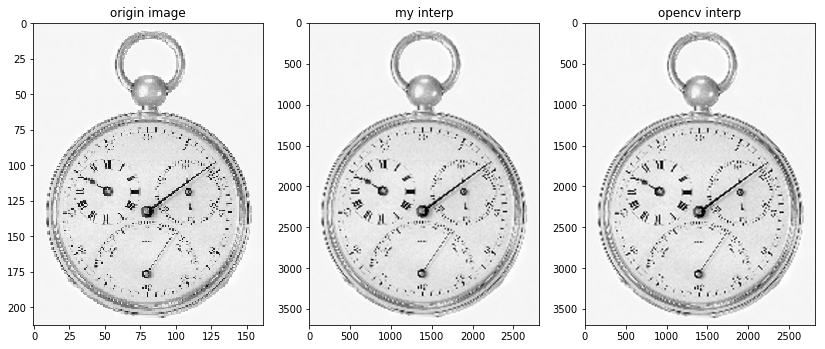

In [10]:
"""运行结果展示"""
result_show_interp(image,bicubic_my,bicubic_opencv)

## 2. Image Averaging

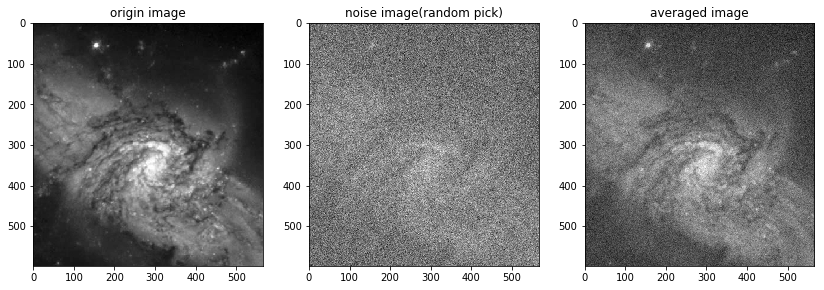

In [14]:
"""
给图像创建均值为0的高斯噪声
"""
def add_noise(image):
    row,col= image.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    noisy = image + gauss
    return noisy

def image_averaging(noise_images):
    final_image = np.zeros_like(noise_images[0],float)
    for i in range(len(noise_images)):        
        final_image += noise_images[i]
    final_image /= len(noise_images)
    return final_image

def result_show(image,noise,averaged):
    ax = []
    fig=plt.figure(figsize=(14, 14))
    ax.append(fig.add_subplot(1, 3, 1))
    ax[-1].set_title("origin image")
    plt.imshow(image,"gray")
    
    ax.append(fig.add_subplot(1, 3, 2))
    ax[-1].set_title("noise image(random pick)")
    plt.imshow(noise,"gray")
    
    ax.append(fig.add_subplot(1, 3, 3))
    ax[-1].set_title("averaged image")
    plt.imshow(averaged,"gray")
    
    plt.show()

# 读取图像
path = 'images/Fig0226(galaxy_pair_original).tif'
image = cv2.imread(path, 0)
image = image.astype(float)/255.

# 随机给图像生成20张带噪声的
noise_images = []
for i in range(20):
    noise_images.append(add_noise(image))
#随机显示带噪声图像与average之后的图像
averaged = image_averaging(noise_images)

noise_random = noise_images[random.randint(0,len(noise_images))] # random.randint(a,b) generates integer in [a,b]
result_show(image,noise_random,averaged)